In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm,binom_test, probplot
import datetime as dt

In [2]:
#df = pd.DataFrame()

In [3]:
# inst = yf.download("EURUSD=X", start="2014-01-01", end="2023-12-31")['Close']
# inst.rename('EURUSD', inplace=True)
# df = df.join(inst, how='outer')

In [4]:
# df = df.iloc[1:]
# df = df.fillna(method='ffill')

In [23]:
#df.to_csv('instrument_data.csv')

In [24]:
df = pd.read_csv('instrument_data.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df['Moutai_USD'] = df['Moutai_CHN']*df['CNYUSD']
df['Shell_USD'] = df['Shell_EUR']*df['EURUSD']
df = df.drop(['Moutai_CHN','Shell_EUR','CNYUSD','EURUSD'],axis=1)

In [32]:
df_log_returns = np.log(df/df.shift(1))[1:]
df_log_returns = df_log_returns.fillna(method='ffill')

C:\Users\Jiaqi\AppData\Roaming\Python\Python311\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [33]:
df_log_returns

,Crude,SP500,USTreasury_30Y,Moutai_USD,Shell_USD
Date,,,,,
2014-01-03,-0.015629,-0.000333,0.002803,-0.015457,-0.001719
2014-01-06,-0.005657,-0.002515,-0.008176,-0.026696,-0.015011
2014-01-07,0.002565,0.006063,-0.004371,-0.001608,0.011129
2014-01-08,-0.014409,-0.000212,0.005653,-0.009420,-0.003645
2014-01-09,-0.007283,0.000348,-0.007716,-0.000519,-0.002300
...,...,...,...,...,...
2023-12-25,0.000000,0.000000,0.000000,0.008571,0.001851
2023-12-26,0.026958,0.004223,-0.002717,-0.008539,-0.000573
2023-12-27,-0.019509,0.001429,-0.024538,-0.002728,-0.000449


Trained without stress

In [34]:
# Equal weighted portfolio
weights = np.array([1/5] * 5) 
df_portfolio = pd.DataFrame(index=df_log_returns.index)
df_portfolio['daily_portfolio_loss'] = -np.dot(df_log_returns, weights)

# get VaR/ES without stress
returns_no_stress = df_log_returns['2014':'2019']
avg_portfolio_loss = -np.dot(returns_no_stress.mean(), weights)
var_cov_matrix = returns_no_stress.cov()
avg_vol = np.sqrt(np.dot(weights.T, np.dot(var_cov_matrix, weights)))
VaR975 = avg_portfolio_loss + avg_vol * norm.ppf(0.975)
VaR99 = avg_portfolio_loss + avg_vol * norm.ppf(0.99)
ES975 = avg_portfolio_loss + avg_vol * (norm.pdf(norm.ppf(0.975)) / (1 - 0.975))
ES99 = avg_portfolio_loss + avg_vol * (norm.pdf(norm.ppf(0.99)) / (1 - 0.99))

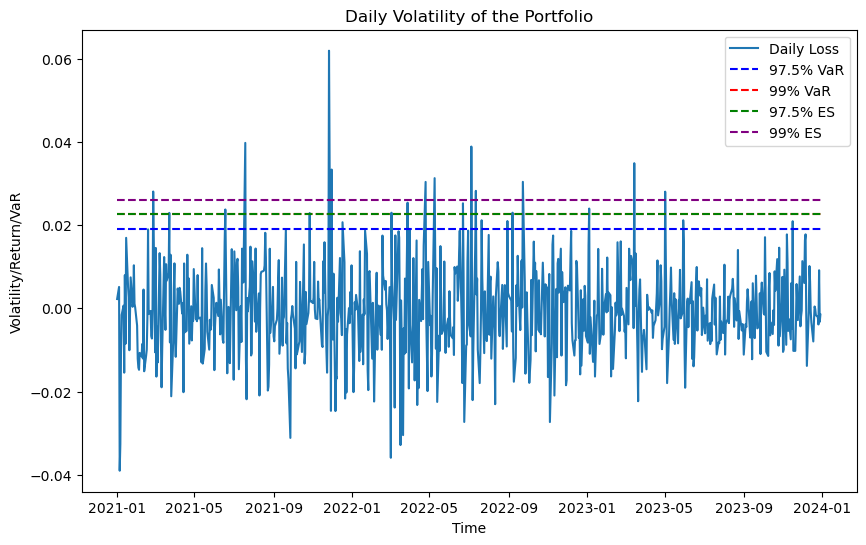

In [35]:
plt.figure(figsize=(10,6))
plt.plot(df_portfolio.daily_portfolio_loss['2021':'2023'],label ='Daily Loss')

xmin = dt.datetime(2021, 1, 1)
xmax = dt.datetime(2023, 12, 31)


plt.hlines(VaR975, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='97.5% VaR')
plt.hlines(VaR99, xmin=xmin, xmax=xmax, colors='red', linestyles='dashed', label='99% VaR')
plt.hlines(ES975, xmin=xmin, xmax=xmax, colors='green', linestyles='dashed', label='97.5% ES')
plt.hlines(ES99, xmin=xmin, xmax=xmax, colors='purple', linestyles='dashed', label='99% ES')


plt.xlabel('Time')
plt.ylabel('Volatility/Return/VaR')
plt.legend()
plt.title('Daily Volatility of the Portfolio')
plt.show()

In [36]:
count_exceeds_VaR975 = (df_portfolio['2021':'2023']['daily_portfolio_loss'] >VaR975).sum()
binom_test_975 = binom_test(count_exceeds_VaR975, len(df_portfolio['2021':'2023']['daily_portfolio_loss']), 0.025, alternative='two-sided')

print(binom_test_975)

0.20622786220359698


C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_14744\3238157811.py:2: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  binom_test_975 = binom_test(count_exceeds_VaR975, len(df_portfolio['2021':'2023']['daily_portfolio_loss']), 0.025, alternative='two-sided')


Trained with stress

In [37]:
# Equal weighted portfolio
weights = np.array([1/5] * 5) 
df_portfolio = pd.DataFrame(index=df_log_returns.index)
df_portfolio['daily_portfolio_loss'] = -np.dot(df_log_returns, weights)

# get VaR/ES without stress
returns_no_stress = df_log_returns['2014':'2020']
avg_portfolio_loss = -np.dot(returns_no_stress.mean(), weights)
var_cov_matrix = returns_no_stress.cov()
avg_vol = np.sqrt(np.dot(weights.T, np.dot(var_cov_matrix, weights)))
VaR975 = avg_portfolio_loss + avg_vol * norm.ppf(0.975)
VaR99 = avg_portfolio_loss + avg_vol * norm.ppf(0.99)
ES975 = avg_portfolio_loss + avg_vol * (norm.pdf(norm.ppf(0.975)) / (1 - 0.975))
ES99 = avg_portfolio_loss + avg_vol * (norm.pdf(norm.ppf(0.99)) / (1 - 0.99))

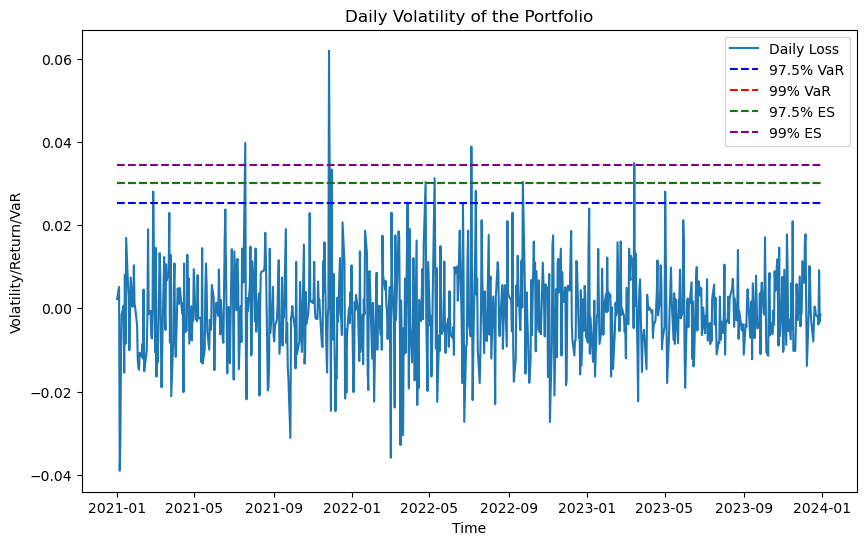

In [38]:
plt.figure(figsize=(10,6))
plt.plot(df_portfolio.daily_portfolio_loss['2021':'2023'],label ='Daily Loss')

xmin = dt.datetime(2021, 1, 1)
xmax = dt.datetime(2023, 12, 31)

# Plotting horizontal lines for each value with datetime x-axis

plt.hlines(VaR975, xmin=xmin, xmax=xmax, colors='blue', linestyles='dashed', label='97.5% VaR')
plt.hlines(VaR99, xmin=xmin, xmax=xmax, colors='red', linestyles='dashed', label='99% VaR')
plt.hlines(ES975, xmin=xmin, xmax=xmax, colors='green', linestyles='dashed', label='97.5% ES')
plt.hlines(ES99, xmin=xmin, xmax=xmax, colors='purple', linestyles='dashed', label='99% ES')


plt.xlabel('Time')
plt.ylabel('Volatility/Return/VaR')
plt.legend()
plt.title('Daily Volatility of the Portfolio')
plt.show()

In [39]:
count_exceeds_VaR975 = (df_portfolio['2021':'2023']['daily_portfolio_loss'] >VaR975).sum()
binom_test_975 = binom_test(count_exceeds_VaR975, len(df_portfolio['2021':'2023']['daily_portfolio_loss']), 0.025, alternative='two-sided')
print(binom_test_975)

0.08561513131568299


C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_14744\90301334.py:2: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  binom_test_975 = binom_test(count_exceeds_VaR975, len(df_portfolio['2021':'2023']['daily_portfolio_loss']), 0.025, alternative='two-sided')


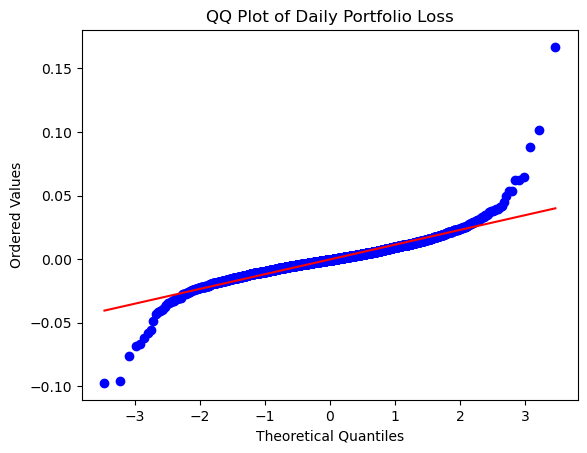

In [40]:
probplot(df_portfolio.daily_portfolio_loss, dist="norm",plot=plt)

plt.title('QQ Plot of Daily Portfolio Loss')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()